

```
# Good till n = 4 after that graphs are good but we are not exactly tracing means our range is not from [-1,1]. It's limiting to 0.5 for n=5 and for n=6 it's 0.015 only. So need to modify.
```



Epoch 0, Loss: 174.3987579345703
Epoch 100, Loss: 1.0063167810440063
Epoch 200, Loss: 1.0043838024139404
Epoch 300, Loss: 1.0038315057754517
Epoch 400, Loss: 1.001994013786316
Epoch 500, Loss: 1.0017080307006836
Epoch 600, Loss: 0.9999642968177795
Epoch 700, Loss: 1.0000535249710083
Epoch 800, Loss: 1.0000195503234863
Epoch 900, Loss: 0.9991925358772278
Epoch 1000, Loss: 0.9983298778533936
Epoch 1100, Loss: 0.998167872428894
Epoch 1200, Loss: 0.9976264238357544
Epoch 1300, Loss: 0.9976844191551208
Epoch 1400, Loss: 0.9967443943023682
Epoch 1500, Loss: 0.9972227811813354
Epoch 1600, Loss: 0.9964110851287842
Epoch 1700, Loss: 0.9963383674621582
Epoch 1800, Loss: 0.99642413854599
Epoch 1900, Loss: 0.9961068630218506
Epoch 2000, Loss: 0.9963550567626953
Epoch 2100, Loss: 0.9967547059059143
Epoch 2200, Loss: 0.9963076114654541
Epoch 2300, Loss: 0.9960327744483948
Epoch 2400, Loss: 0.9969128966331482
Epoch 2500, Loss: 0.9965653419494629
Epoch 2600, Loss: 0.9956843852996826
Epoch 2700, Loss: 

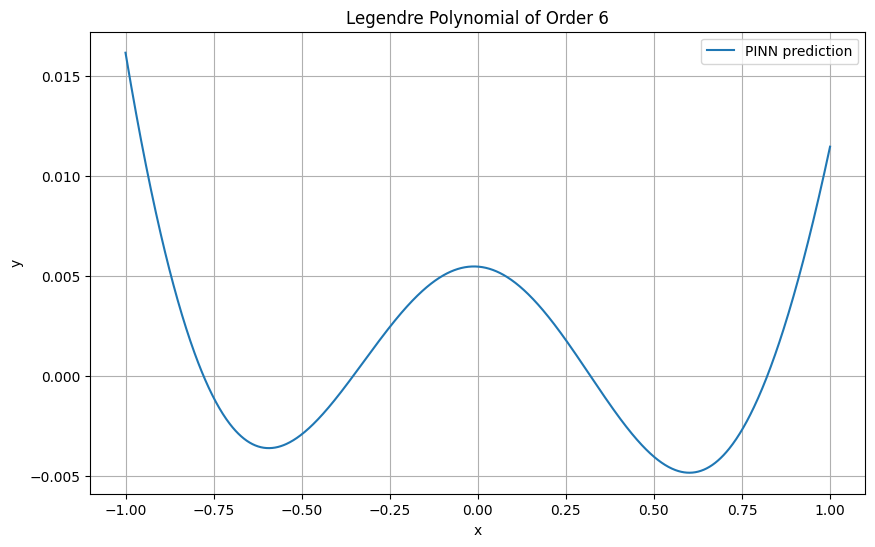

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class PINN:
    def __init__(self, k):
        self.k = k
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(50, activation='tanh', input_shape=(1,)),
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(50, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])
        return model

    def legendre_equation(self, x, y, dy_dx, d2y_dx2):
        return (1 - x**2) * d2y_dx2 - 2 * x * dy_dx + self.k * (self.k + 1) * y

    def boundary_values(self):
        if self.k % 2 == 0:  # even k
            return 1.0, 1.0  # y(-1) = 1, y(1) = 1
        else:  # odd k
            return -1.0, 1.0  # y(-1) = -1, y(1) = 1

    def custom_mse(self, y_true, y_pred):
        # Custom Mean Squared Error implementation
        return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.cast(tf.shape(y_true)[0], tf.float32)

    def loss(self, x):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x)
            y = self.model(x)
            dy_dx = tape.gradient(y, x)
        d2y_dx2 = tape.gradient(dy_dx, x)

        # Equation loss
        eq_residual = self.legendre_equation(x, y, dy_dx, d2y_dx2)
        eq_loss = self.custom_mse(tf.zeros_like(eq_residual), eq_residual)

        # Boundary condition loss
        y_minus_1, y_plus_1 = self.boundary_values()
        bc_pred = tf.concat([self.model(tf.constant([[-1.]])), self.model(tf.constant([[1.]]))], axis=0)
        bc_true = tf.constant([[y_minus_1], [y_plus_1]], dtype=tf.float32)
        bc_loss = self.custom_mse(bc_true, bc_pred)

        return eq_loss + bc_loss

    def train(self, epochs=20000):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

        @tf.function
        def train_step():
            x = tf.random.uniform((1000, 1), -1, 1)
            with tf.GradientTape() as tape:
                loss_value = self.loss(x)
            gradients = tape.gradient(loss_value, self.model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
            return loss_value

        for epoch in range(epochs):
            loss = train_step()
            if epoch % 100 == 0:
                print(f'Epoch {epoch}, Loss: {loss.numpy()}')

    def predict(self, x):
        return self.model(x).numpy()

# Example usage
k = 6  # Order of Legendre polynomial
pinn = PINN(k)
pinn.train()

# Generate predictions
x = np.linspace(-1, 1, 1000).reshape(-1, 1)
y_pred = pinn.predict(x)

# plotting original solution as :


# Plot results
plt.figure(figsize=(10, 6))
plt.plot(x, y_pred, label='PINN prediction')
plt.title(f"Legendre Polynomial of Order {k}")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

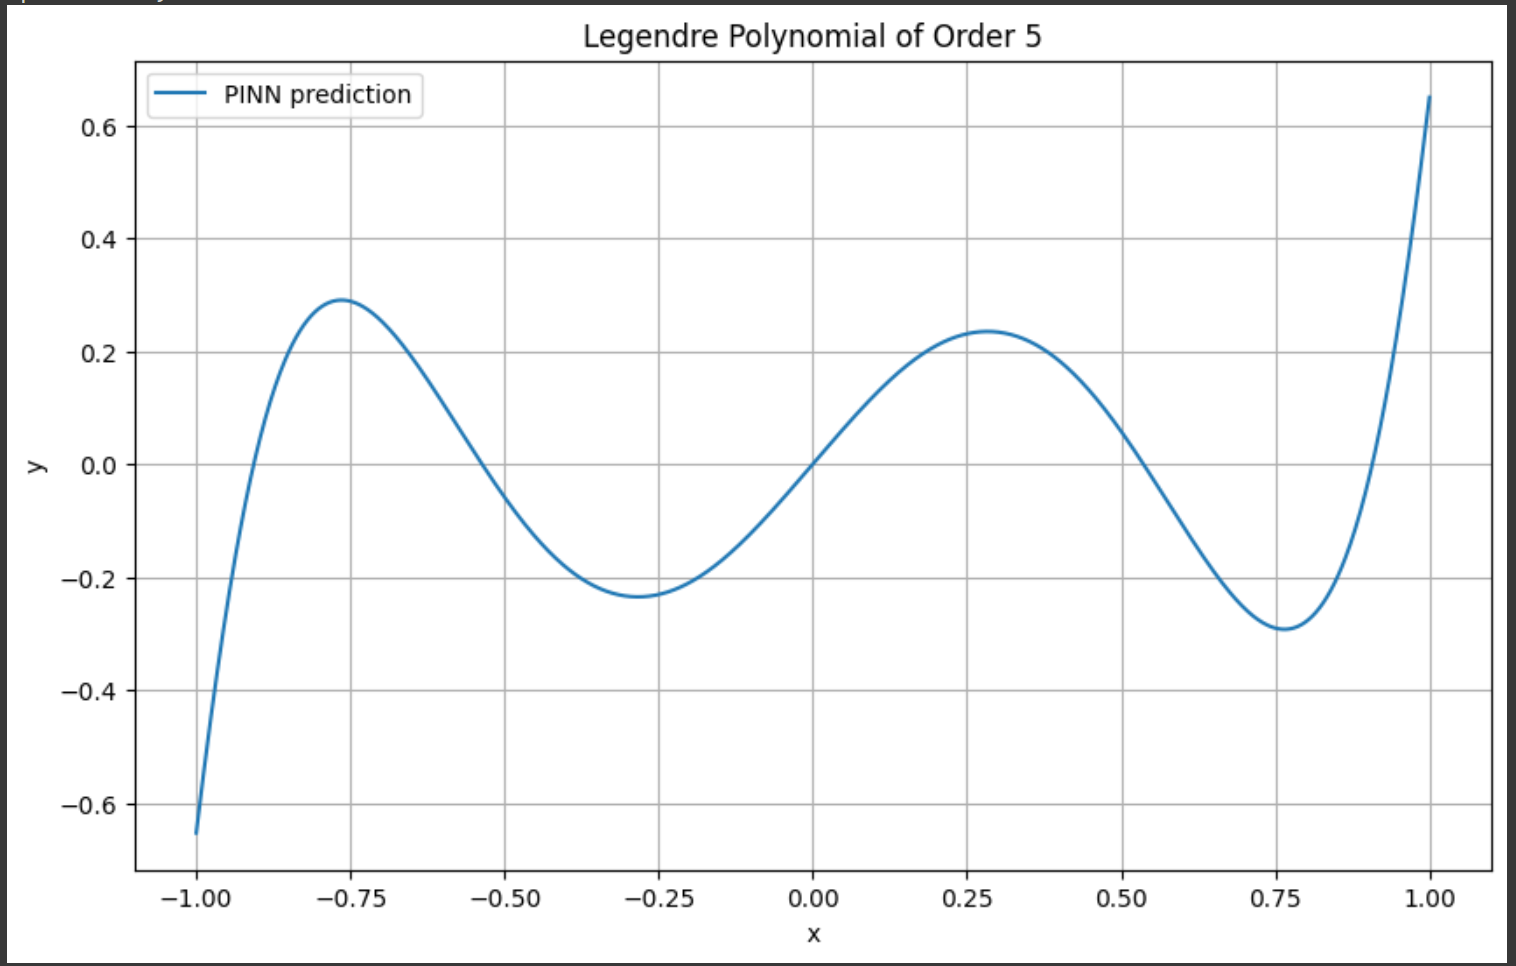

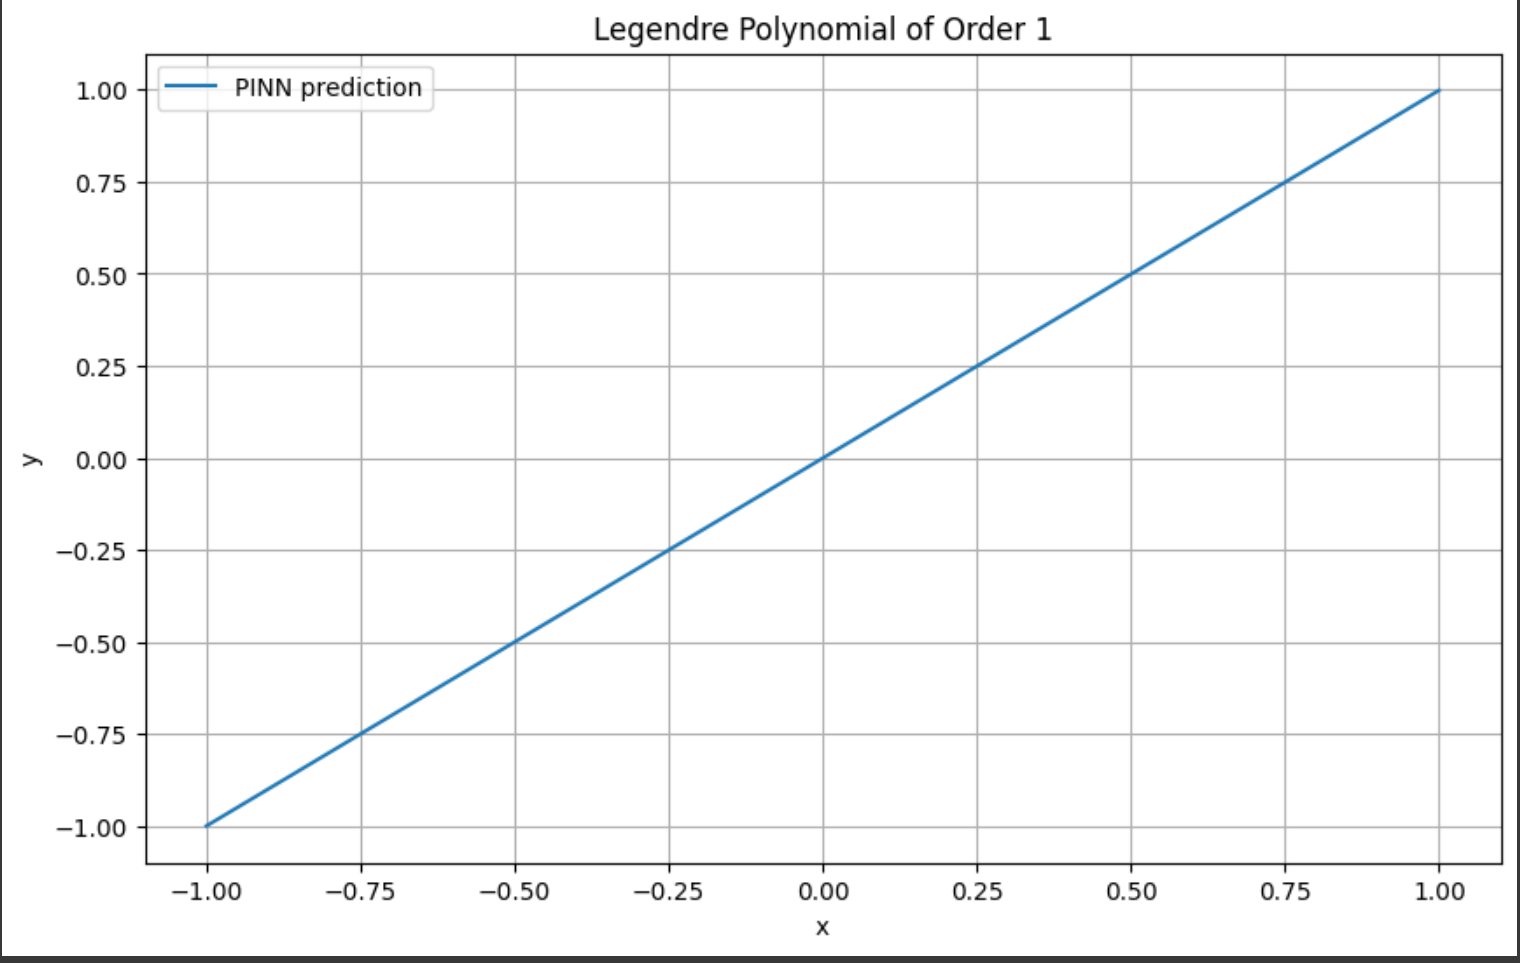

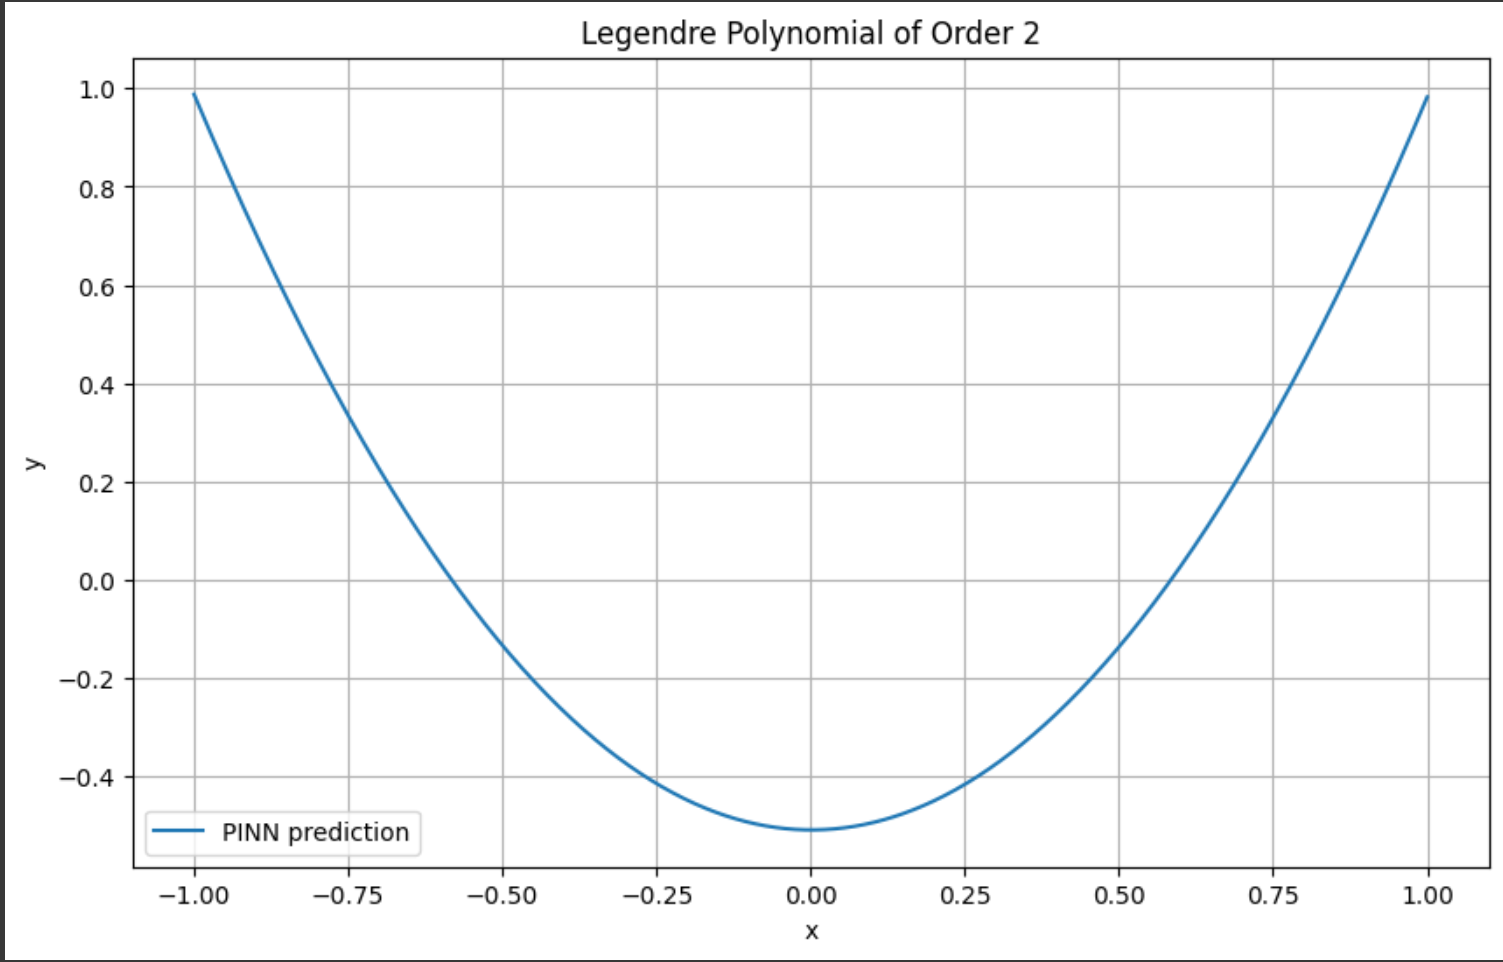

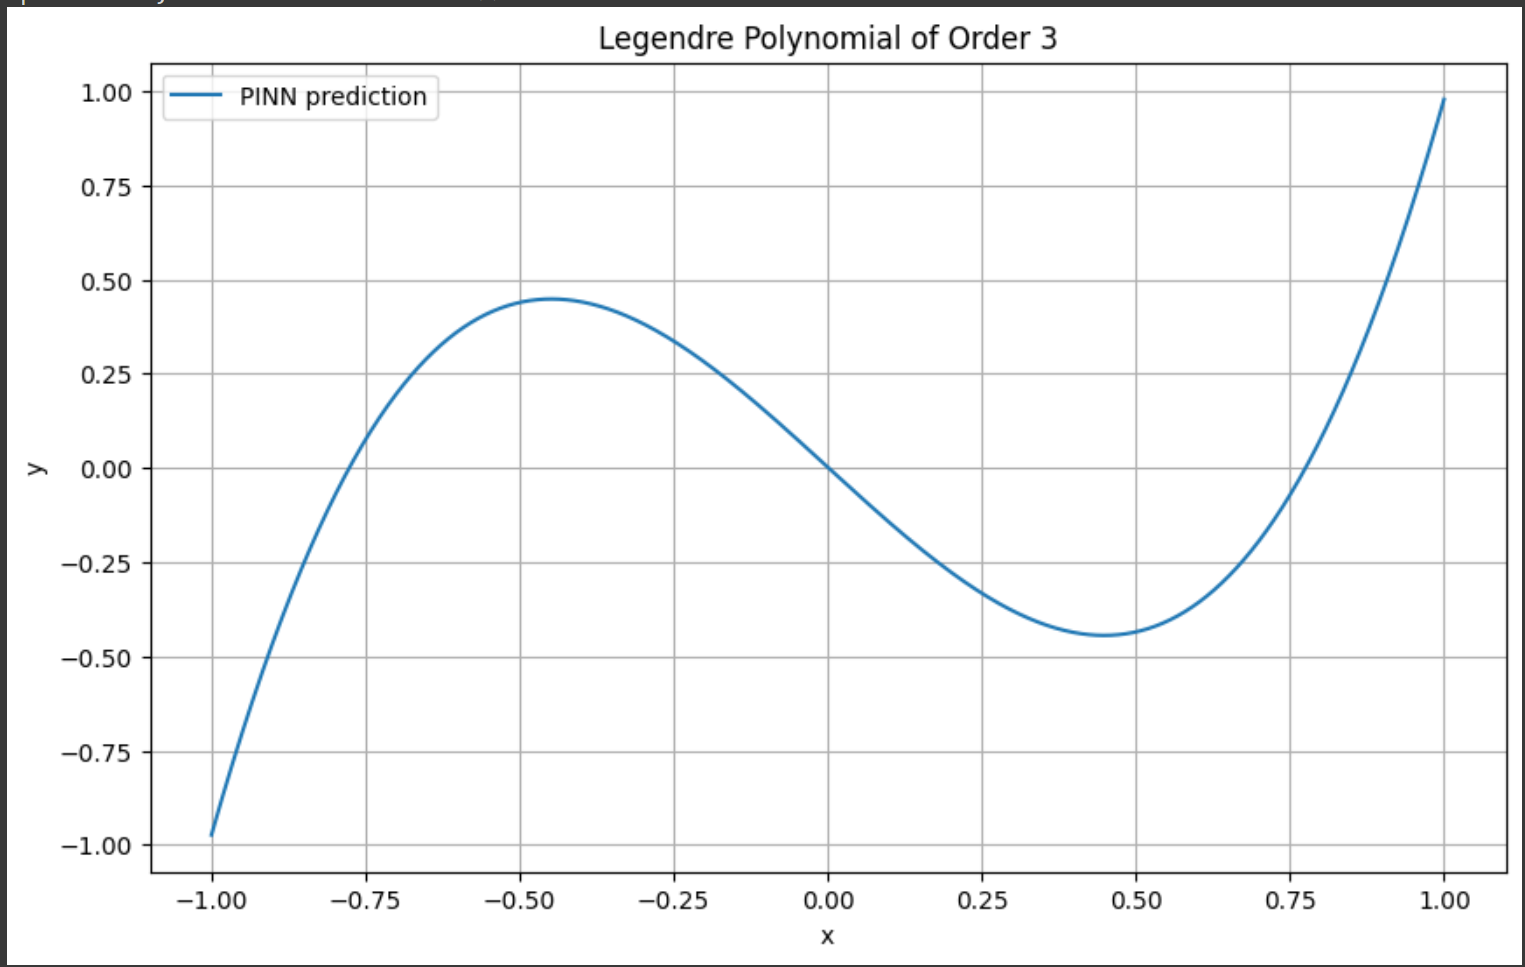

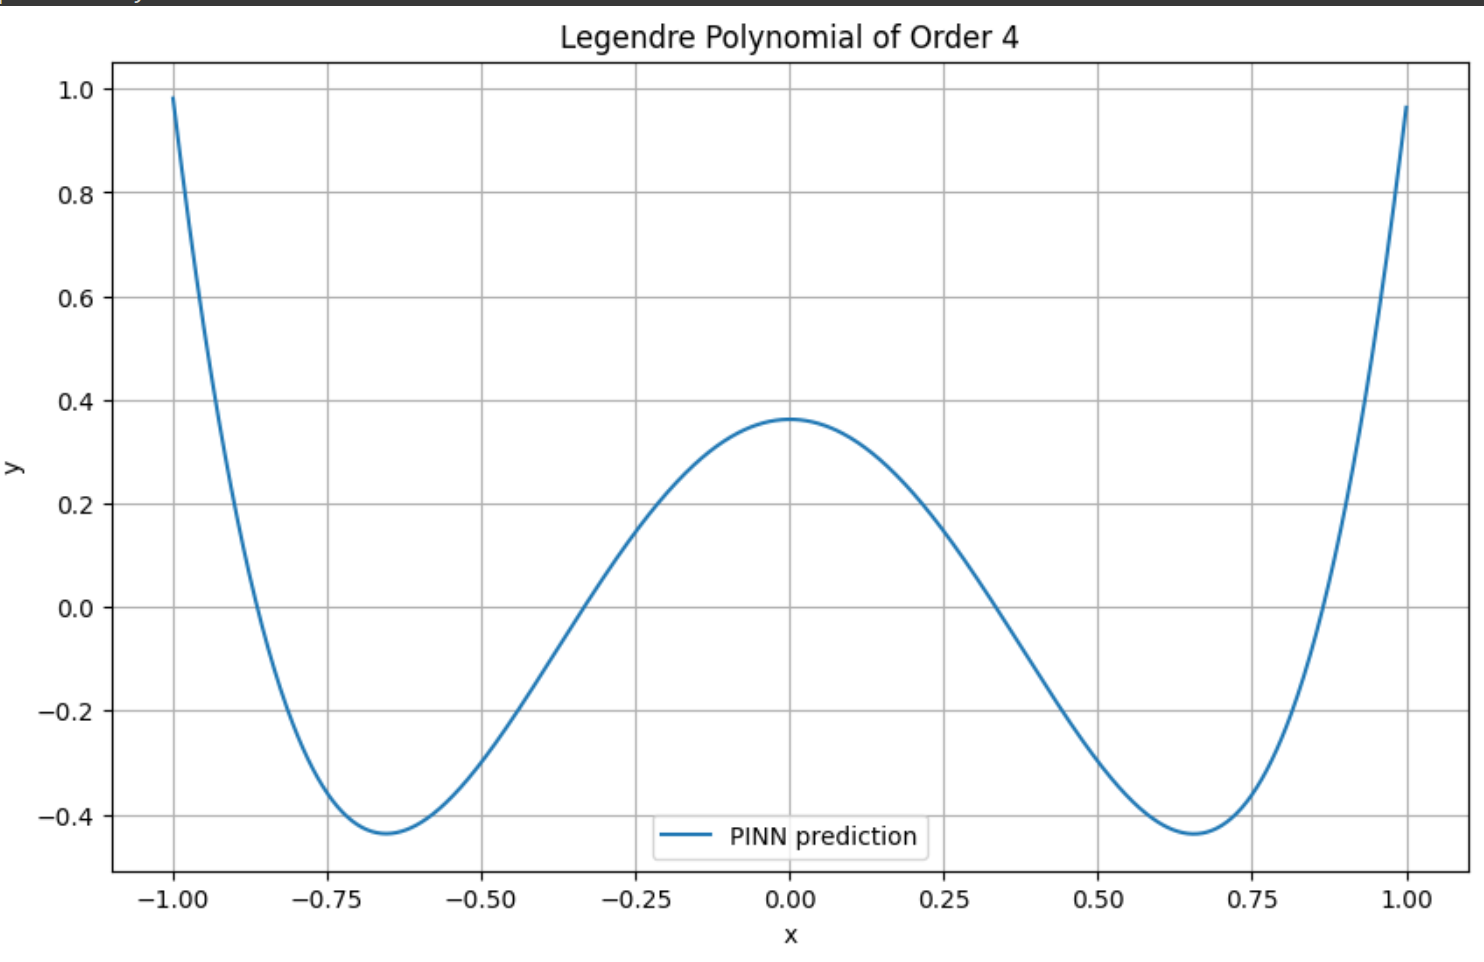

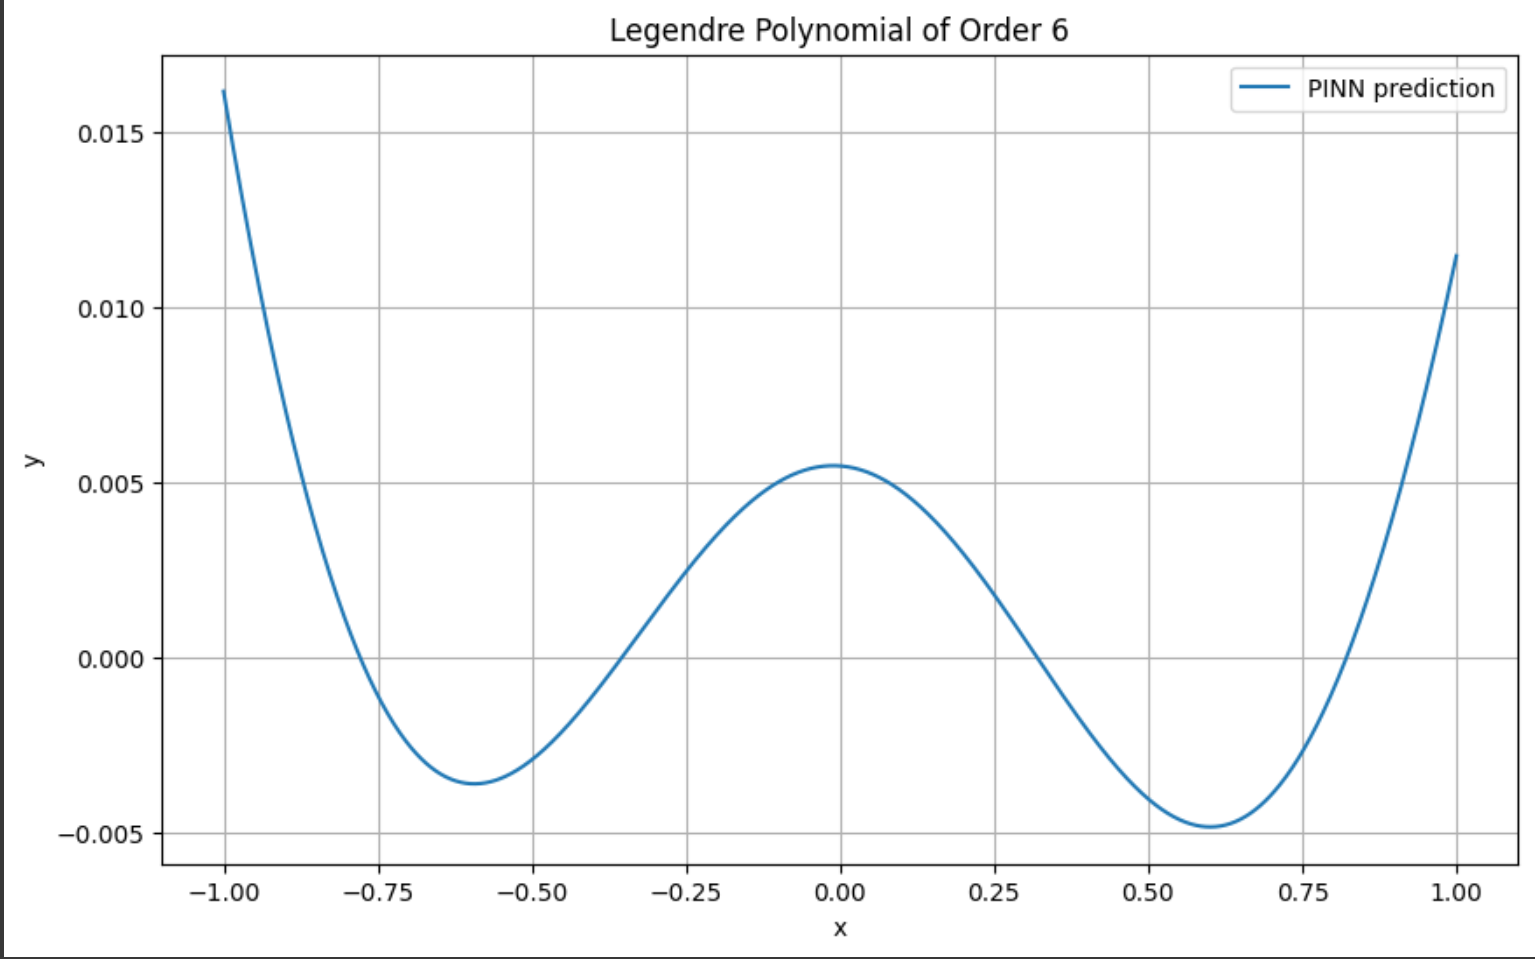